In [1]:
import sys
import os
sys.path.append(os.getcwd())

import datetime
import h5py as h5
import numpy as np
#import pandas as pd
import utils

from obspy.core import UTCDateTime as udt
import matplotlib.pyplot as plt
import fast_matched_filter as fmf
from time import time as give_time

# to recognize the user
import getpass


Matched-filter GPU is not compiled! Should be here: /home/sanchezh/anaconda3/envs/fmf_tuto/lib/python3.7/site-packages/fast_matched_filter/lib/matched_filter_GPU.so


In [2]:
# 
#os.system('rm -r /home/insar/Bureau/datos/output')
#os.system('mkdir /home/insar/Bureau/datos/output')
#os.system('mkdir /home/insar/Bureau/datos/output/cc_sums')
#os.system('mkdir /home/insar/Bureau/datos/output/detections')
#os.system('mkdir /home/insar/Bureau/datos/output/plots')

os.system('rm -r /home/sanchezh/datos/output')
os.system('mkdir /home/sanchezh/datos/output')
os.system('mkdir /home/sanchezh/datos/output/cc_sums')
os.system('mkdir /home/sanchezh/datos/output/detections')
os.system('mkdir /home/sanchezh/datos/output/plots')


0

In [3]:

# generate a list with dates to loop over 
start_date_for_loop = '2022-05-26'
end_date_for_loop = '2022-05-27'
print_intermediate_step = True

# set arguments for fmf
matched_filter_step = 1 # if set to 1, the sliding windows are taken every sample
architecture = 'cpu' # run fmf on GPUs (other option is 'cpu')
print_intermediate_step = True
save_intermediate_plots = True
merge_cc_sum_now = False



In [4]:
magnitude_date_time_eq = '2022-05-26T12:02:23.000000'

path = '/home/insar/Bureau/'
path = '/home/sanchezh/'
path_splitted_continuous_data =  path + 'datos/preparados/waveforms_'
path_template = path+'datos/templates/' + magnitude_date_time_eq+'.hdf5'
path_cc_sum = path+'datos/output/cc_sums/'
path_new_detection = path+'datos/output/detections/'
path_for_plots = path+'datos/output/plots/'

template = utils.load_template(path_template)

# format the inputs for fmf by adding a new dimension
# with 1 element (because this example only uses one template)
template_array = template['waveforms'][np.newaxis, :]


moveouts = np.hstack( (template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_P'].reshape(-1, 1)) )
moveout_array = moveouts[np.newaxis, :]


# fmf requires a weight matrix used to compute the weighted correlation
# coefficient sum
weight_array = np.ones_like(moveout_array, dtype=np.float32)
n_stations = weight_array.shape[1]
n_components = weight_array.shape[2]
# normalize so that the max value is 1 (optional)
weight_array /= np.float32(n_stations * n_components)
#weight_array[0][0][0] = 0.
#weight_array[0][0][1] = 0.
#weight_array[0][0][2] = 0.

print(weight_array)


if print_intermediate_step==True:
    print('Shape of the weight array: ', weight_array.shape)
    print('Shape of the moveout array: ', moveout_array.shape)
    print('Shape of the template array: ', template_array.shape)

[[[0.33333334 0.33333334 0.33333334]]]
Shape of the weight array:  (1, 1, 3)
Shape of the moveout array:  (1, 1, 3)
Shape of the template array:  (1, 1, 3, 100)


In [5]:
# dates to loop
start_date_to_loop = datetime.datetime.strptime(start_date_for_loop, '%Y-%m-%d')
end_date_to_loop = datetime.datetime.strptime(end_date_for_loop, '%Y-%m-%d')
date_generated = [start_date_to_loop + datetime.timedelta(days=x) for x in range(0,(end_date_to_loop-start_date_to_loop).days)]
dates_to_loop_over = []

for date in date_generated:
    date = date.strftime('%Y-%m-%d')
    dates_to_loop_over.append(date)
time_range = dates_to_loop_over[0]+'_'+dates_to_loop_over[-1]

print(dates_to_loop_over)


['2022-05-26']


1966 correlation computations were skipped on the 0-th template. Can be caused by zeros in data, or too low amplitudes (try to increase the gain).


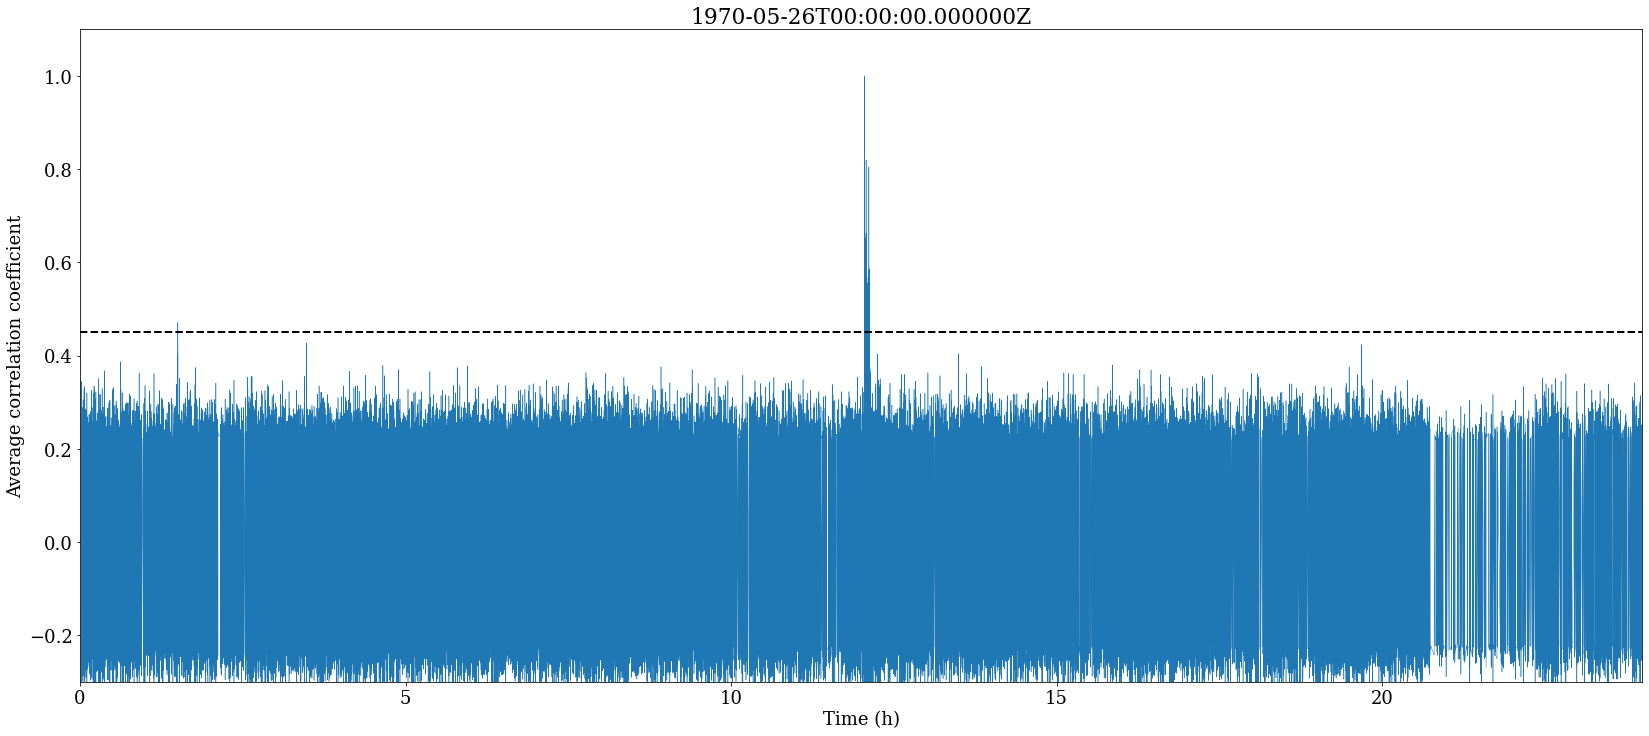

metadata and waveforms are Python lists with lengths 1 and 1        (respectively) because we use a single template.

Elements of metadata are dictionaries with information on:
 ['template_id', 'stations', 'components', 'origin_times', 'correlation_coefficients']


Elements of waveforms are numpy arrays with shape:
 (16, 1, 3, 3000)
16 events detected with Template 0


In [7]:
### calculate the fast matched filtering
#cc_sum_all 
#nr_templates = 0
#print(weight_array)
n_mad = 9

for i in range(len(dates_to_loop_over)):
    data = utils.load_data(path_splitted_continuous_data+dates_to_loop_over[i]+'.hdf5')

    cc_sum = fmf.matched_filter(template_array,
                                moveout_array,
                                weight_array,
                                data['waveforms'],
                                matched_filter_step,
                                arch=architecture)
    # merge all cc_sums directly
    if merge_cc_sum_now == True:
        if i ==0:
            cc_sum_all = np.zeros((nr_templates, np.shape(cc_sum)[1]*len(dates_to_loop_over)))

        cc_sum_all[i*np.shape(cc_sum)[1]:(i+1)*np.shape(cc_sum)[1]] = cc_sum
        #print(type(cc_sum))


        with h5.File(path_cc_sum+'merged.hdf5', mode='w') as f:
        #with h5.File(path_cc_sum+'TEEEST'+'.hdf5', mode='w') as f:
            f.create_dataset('cc_sum', data=cc_sum_all,compression='gzip')
                #f.close()
    with h5.File(path_cc_sum+magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'.hdf5', mode='w') as f:
        #with h5.File(path_cc_sum+'TEEEST'+'.hdf5', mode='w') as f:
        f.create_dataset('cc_sum', data=cc_sum,compression='gzip')


    if save_intermediate_plots==True:
        # plot the cc time series
        figsize = (28, 12)
        plt.figure('cc_sum', figsize=figsize)
        time = np.linspace(0., float(cc_sum.shape[1]) / data['metadata']['sampling_rate'], cc_sum.shape[1])
        smart_plot = np.abs(cc_sum[0, :]) > 2.5 * np.std(cc_sum[0, :])
        plt.plot(time[smart_plot]/3600, cc_sum[0, smart_plot], lw=0.5)
        #plt.plot(datelist, cc_sum[0,:], lw=0.5)
        plt.axhline(0.45, lw=2, ls='--', color='k')
        plt.xlabel('Time (h)')
        plt.ylabel('Average correlation coefficient')
        plt.ylim(-0.3, 1.1)
        plt.xlim(time.min(), time.max()/3600)
        plt.title(data['metadata']['date'])
        #plt.savefig(path_for_plots+'cc_sum_plots/'+magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'_correlation_coefficients.png')
        font = {'family': 'serif',
        'size': 18}
        plt.rc('font', **font)
        plt.show()

    moveouts = np.hstack( (template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_P'].reshape(-1, 1)) )
    moveout_array = moveouts[np.newaxis, :]

    metadata, waveforms = utils.extract_new_detections(data, cc_sum, moveout_array, n_mad=n_mad)

    reference_time = udt("2022-01-01T00:00:0.00").timestamp
    for t_id in range(len(metadata)):
        for orig in range(len(metadata[t_id]['origin_times'])):
            metadata[t_id]['origin_times'][orig] =  metadata[t_id]['origin_times'][orig] + reference_time
            #print(udt(metadata[t_id]['origin_times'][orig]))        
    
    #print(metadata)
    if print_intermediate_step==True:
        print('metadata and waveforms are Python lists with lengths {:d} and {:d}\
        (respectively) because we use a single template.\n'.format(len(metadata), len(waveforms)))
        print('Elements of metadata are dictionaries with information on:\n', list(metadata[0].keys()))
        print('\n')
        print('Elements of waveforms are numpy arrays with shape:\n', waveforms[0]['waveforms'].shape)
    utils.write_new_detections(magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'_{:d}_mad'.format(int(n_mad)), metadata, waveforms, db_path=path_new_detection)


0
0
1.00 2022-05-26T12:02:42
0.82 2022-05-26T12:04:15
0.80 2022-05-26T12:06:48


/home/sanchezh/anaconda3/envs/fmf_tuto/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


05-26T12:02:42


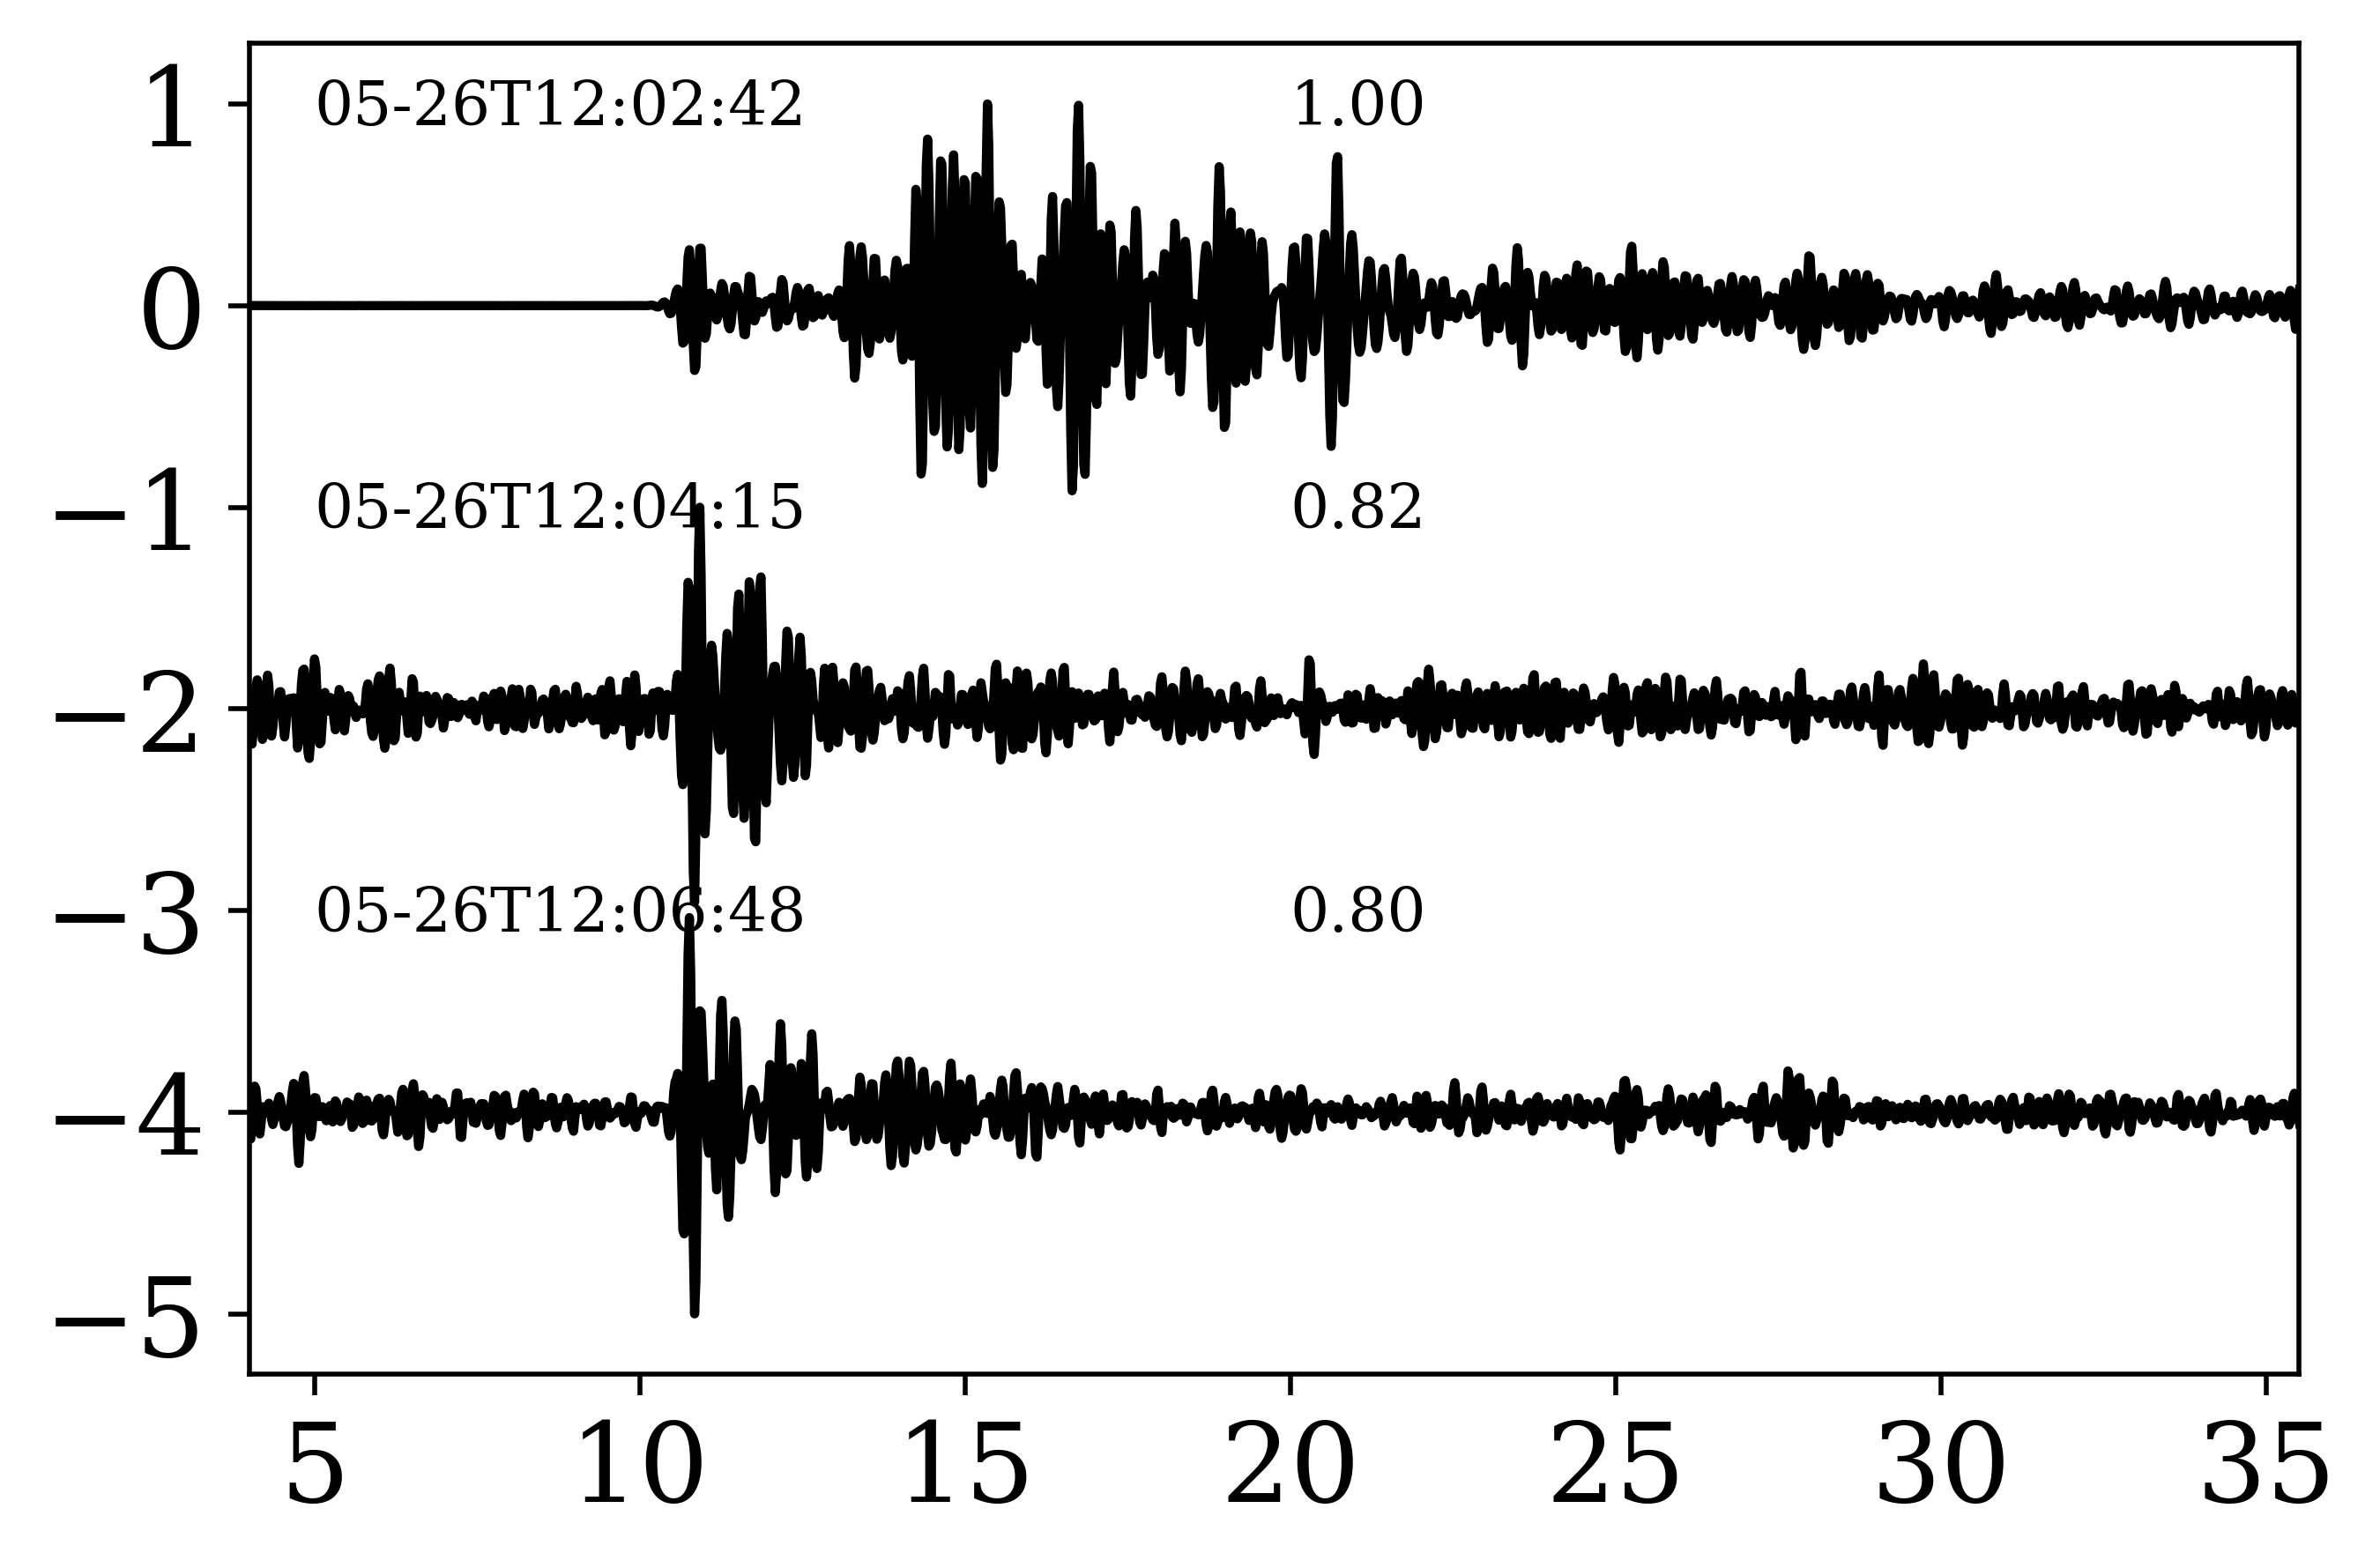

In [8]:
dates_to_loop_over = ['2022-05-26']
n_mad = 9
threshold = 0.7
data = np.zeros((50, 3000), dtype=float)
k = 0
cc = []
dates = []
dates_utm = []
for i in np.arange(0,1,1):
    id_day = i

    filename = magnitude_date_time_eq+'_'+dates_to_loop_over[id_day]+'_{:d}_mad'.format(int(n_mad))
    n_best = 5
    # retrieve the extracted events
    tid = 0 # since we only used one template
    try:
        detections = utils.load_detections(path_new_detection+filename, tid)
        for id_cc in range(len(detections['metadata']['correlation_coefficients'])):
            if detections['metadata']['correlation_coefficients'][id_cc] > threshold:
                date_utm = udt(detections['metadata']['origin_times'][id_cc])
                dates_utm.append(date_utm)
                #print(date_utm)
                date_str = date_utm.strftime('%Y-%m-%dT%H:%M:%S')
                dates.append(date_str)
                #print(detections['metadata']['correlation_coefficients'][id_cc],date_str)
                cc.append(detections['metadata']['correlation_coefficients'][id_cc])
                #print(id_cc, detections['metadata']['correlation_coefficients'][id_cc],filename)
                #print(len(detections['waveforms'][0][id_cc][2]))
                data[k][:] = detections['waveforms'][id_cc][0][2]
                k += 1  
        #print(len(detections[0]))
        #print(filename)
        #print('detections is a Python dictionary with categories:\n', list(detections.keys()))
        #print('\n')
        #print('metadata is also a Python dictionary:\n', list(detections['metadata'].keys()))
        #utils.plot_n_detections(detections, n_best, template, path_to_plot=path_for_plots+dates_to_loop_over[id_day]+'_', center_event='', station_idx=0)
    except:
        a = 1
ids = np.linspace(0, 50, 50)
time = np.linspace(0, 60, 3000) 
#print(ids,time)
#print(len(time),len(ids),len(data))
#print(cc)
#print(len(detections['waveforms'][0]),'aa')
#plt.plot(detections['waveforms'][0][0][2])
id_single = []
for i in range(len(cc)):#len(cc)):
    res_dates = []
    for j in range(len(cc)):
        res_dates.append(abs(dates_utm[j]-dates_utm[i]))
    res_dates = np.array(res_dates)
    id_save = np.where(res_dates < 10.0)[0]
    if len(id_save) > 1:
        cc_check = []
        for id_s in id_save:
            cc_check.append(cc[id_s])
        id_cc_max = np.where(cc_check == max(cc_check))[0][0]
        print(id_save[id_cc_max])
        id_single.append(id_save[id_cc_max])
    else:
        id_single.append(id_save[0])

id_single = np.unique(id_single)

fig, ax1 = plt.subplots(dpi=500)

k = 0
for id_i in id_single:
    res = "{:.2f}".format(cc[id_i])
    ax1.plot(time,data[id_i,:]/max(abs(data[id_i,:])) -2*(k),color='black')
    ax1.text(20, -2*(k)+0.9, res, size=10)
    ax1.text(5., -2*(k)+0.9, dates[id_i][5:], size=10)
    print(res,dates[id_i])
    k += 1
    #except:
    #    a=1
    #    print('a')
#plt.show()
ax1.set_xlim((4, 35.5))
font = {'family': 'serif',
        'size': 7}
plt.rc('font', **font)
fig.show()
fig.savefig('detections.png')
print(dates[0][5:])